## Understanding the cause of hallucinations

In [4]:
import json
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer


### 1. Inspect the token length of the inputs

In [5]:
# Note: to access meta-llama you have to first accept the licence agreement
hugg_key = os.environ['HUGGINGFACE_KEY']

tokenizer = AutoTokenizer.from_pretrained(
                'meta-llama/Llama-3.2-3B-Instruct', 
                token=hugg_key)



In [6]:
prompts = []
with open('../outputs/prompts_20241223_210613.jsonl', 'r') as in_f:
    prompts = [json.loads(line) for line in in_f.readlines()]


In [7]:
prompts_encoded_lengths = dict()

for entry in prompts:
    id = entry['qid']
    text = entry['prompt']
    prompts_encoded_lengths[id] = len(tokenizer.encode(text))


In [8]:
lengths_series = pd.Series(prompts_encoded_lengths)
lengths_series.describe()


count    7098.000000
mean     2487.146097
std       626.376110
min      1705.000000
25%      2045.000000
50%      2314.000000
75%      2753.500000
max      6276.000000
dtype: float64

Text(0, 0.5, 'Count')

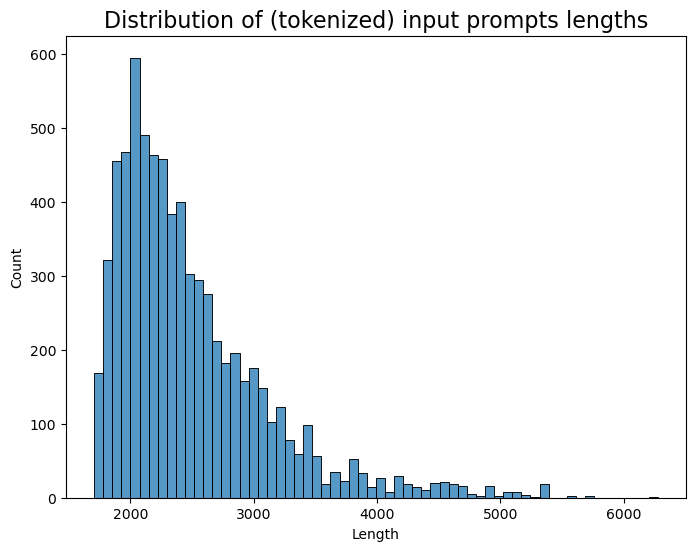

In [9]:
plt.figure(figsize=(8, 6))
sns.histplot(data=lengths_series)
plt.title("Distribution of (tokenized) input prompts lengths", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")


From these summary statistics, the longest input prompt is of size 6276, is below the context window size of 8192 tokens. Moreover, from the lengths distributions, we can observe that the vast majority of the input prompts are well below the context window size.

### 2. Correlation between input length and hallucination?

In [10]:
predictions = []
with open('../outputs/responses_llama3.2_20241224_18:43:28.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df

template_answer_mask = predictions_df['answer'].str.contains(r'^ANSWER: \w+', case=False, regex=True)

verbose_answer_ids = predictions_df[~template_answer_mask].index
print(f"Ratio of verbose answers to the total: {len(verbose_answer_ids)/predictions_df.shape[0]:0.2f}")


Ratio of verbose answers to the total: 0.29


Text(0, 0.5, 'Count')

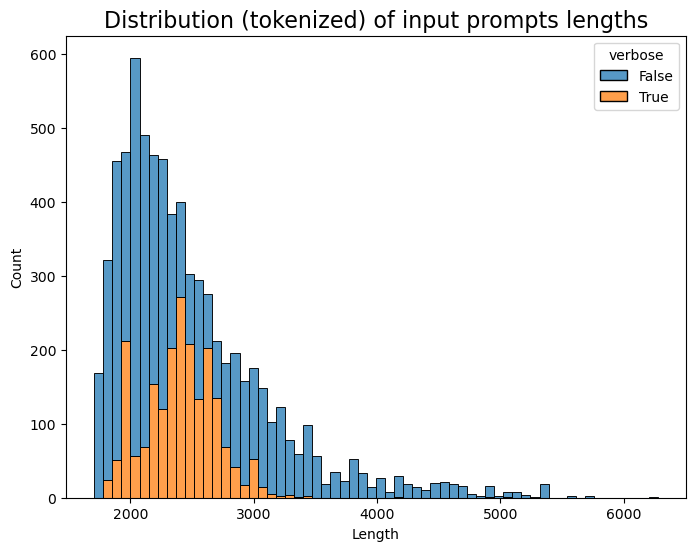

In [11]:
plot_data = pd.DataFrame(lengths_series, columns=['length'])
plot_data['verbose'] = ~template_answer_mask

plt.figure(figsize=(8, 6))
sns.histplot(plot_data,
             x='length', hue='verbose',
             multiple='stack', edgecolor='black')
plt.title("Distribution (tokenized) of input prompts lengths", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")


The plot of the distributions, distinguishing from inputs with a verbose answers and those with a concise one following the template, suggest that there's **a very weak correlation** between input length and a resulting verbose answer.

### 3. Experiment with temperature set to 0.1 (from 0.8)

In [12]:
predictions = []
with open('../outputs/responses_llama3.2_20250125_14:35:33.jsonl') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df

template_answer_mask = predictions_df['answer'].str.contains(r'^ANSWER: \w+', case=False, regex=True)

verbose_answer_ids = predictions_df[~template_answer_mask].index
print(f"Ratio of verbose answers to the total: {len(verbose_answer_ids)/predictions_df.shape[0]:0.2f}")


Ratio of verbose answers to the total: 0.23


Text(0, 0.5, 'Count')

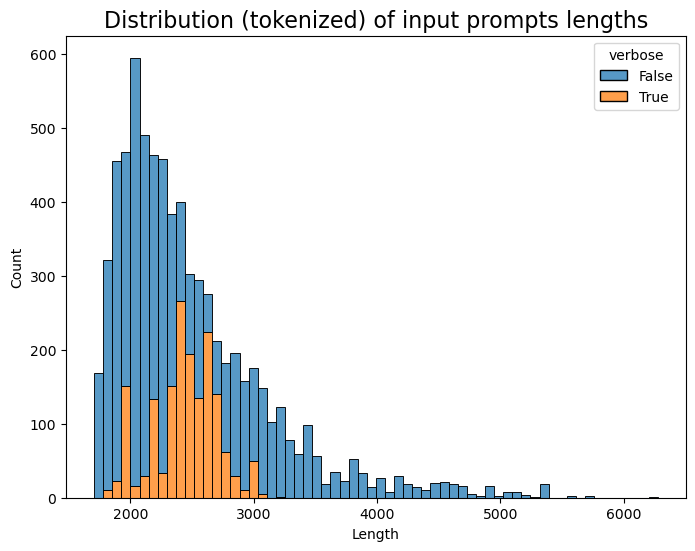

In [13]:
plot_data = pd.DataFrame(lengths_series, columns=['length'])
plot_data['verbose'] = ~template_answer_mask

plt.figure(figsize=(8, 6))
sns.histplot(plot_data,
             x='length', hue='verbose',
             multiple='stack', edgecolor='black')
plt.title("Distribution (tokenized) of input prompts lengths", fontsize=16)
plt.xlabel("Length")
plt.ylabel("Count")
